# NSGA-II brute force test

In [10]:
import numpy as np
from KnackpackData import getEncoded,weights,values,max_weight,n_items
max_weight = np.float32(max_weight)
values = values.astype('float32')
weights = weights.astype('float32')
print(values)
print(weights)

[0.53949165 0.92803377 0.13404392 0.6492544  0.70015407 0.11729955
 0.45870945 0.2223288  0.13452856 0.3323505  0.3287888  0.62103146
 0.1657842  0.08188698 0.03397051 0.4613329 ]
[0.6083088  0.97587323 0.03976481 0.7476777  0.38438    0.40872937
 0.28672832 0.79154503 0.7408737  0.54517394 0.11215131 0.04169534
 0.7534757  0.09937005 0.02755255 0.00546339]


In [11]:
from numba import njit,prange
@njit("int32(boolean[::1],boolean[::1])",nogil = True,fastmath=True)
def dominates(first, second):
    thisWeight= 0
    thisValue = 0
    otherWeight = 0
    otherValue= 0
    for i in prange(n_items):
        if first[i]:
            thisWeight += weights[i]
            thisValue  += values[i]
        if second[i]:
            otherWeight += weights[i]
            otherValue +=values[i]
    if thisWeight>max_weight:
        thisValue = -1
    if otherWeight>max_weight:
        otherValue = -1
    if (thisValue >= otherValue and thisWeight < otherWeight) or (thisValue > otherValue and thisWeight <= otherWeight):
        return 1
    elif (thisValue <= otherValue and thisWeight > otherWeight) or (thisValue < otherValue and thisWeight >= otherWeight):
        return -1
    else:
        return 0
@njit(nogil = True,fastmath=True,parallel = True)
def getResult(population):
    res = np.zeros(len(population))
    for i in prange(len(population)):
        for j in prange(len(population)):
            res[i] += dominates(population[i],population[j])
    return res

In [12]:
population = getEncoded()
print(len(population))
%time results = getResult(population)

65536
CPU times: user 2min 5s, sys: 36 ms, total: 2min 5s
Wall time: 16.1 s


60694.0
65536
43571


array([ True, False,  True, False,  True, False,  True, False, False,
       False,  True,  True, False, False,  True,  True])

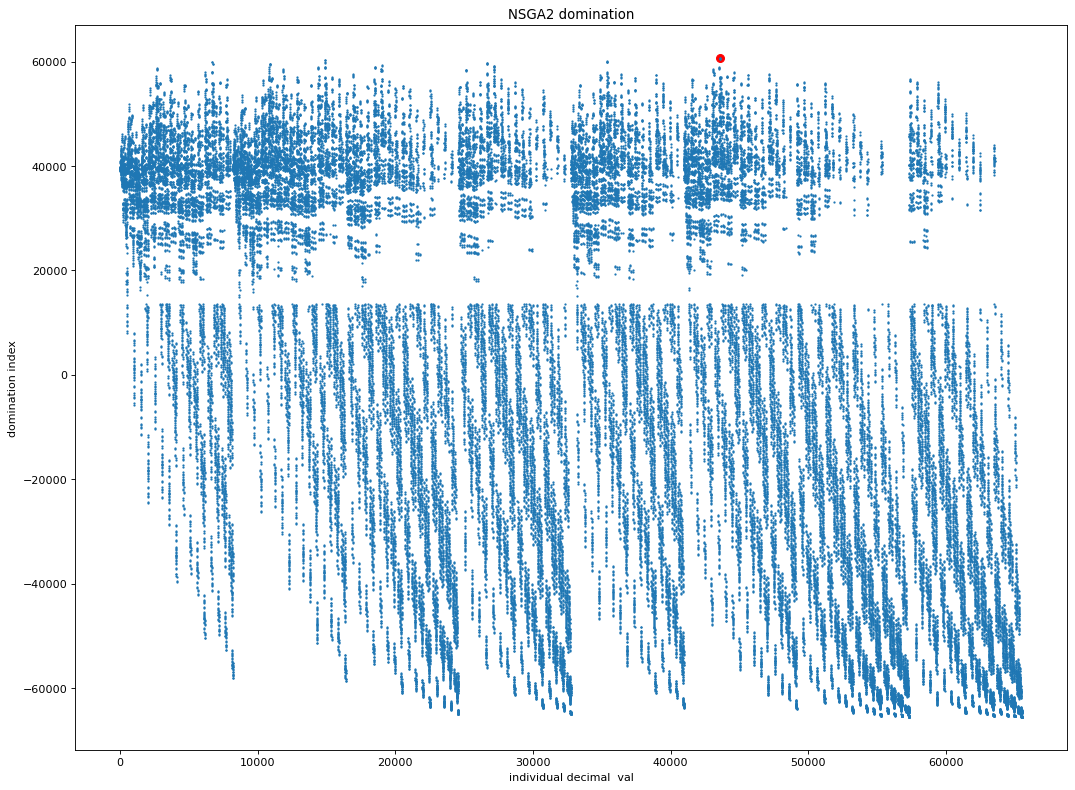

In [13]:
import matplotlib.pyplot as plt
best_index = np.argmax(results)
best_index
print(results[best_index])
plt.figure(figsize=(16, 12), dpi=80)
plt.title("NSGA2 domination")
plt.xlabel("individual decimal  val")
plt.ylabel("domination index")
plt.scatter(best_index,results[best_index],c="r",s=50)
plt.scatter(range(len(results)),results,s=1)
print(len(results))
print(best_index)
population[best_index]

### Weryfikacja hipotezy, że NSGA-II wybiera takie przedmioty, dla których wartość > waga.

In [5]:
weights_sum = 0
for x in zip(values, weights, population[best_index]):
    if x[2]:
        print(f"Weight: {x[1]} | Value: {x[0]}")
        weights_sum += x[1]
    elif x[0] > x[1]:
        print(f"[Not taken] Weight: {x[1]} | Value: {x[0]}")
weights_sum    

Weight: 0.6083087921142578 | Value: 0.5394916534423828
Weight: 0.03976481035351753 | Value: 0.13404391705989838
Weight: 0.3843800127506256 | Value: 0.7001540660858154
Weight: 0.2867283225059509 | Value: 0.4587094485759735
Weight: 0.11215130984783173 | Value: 0.32878878712654114
Weight: 0.04169533774256706 | Value: 0.6210314631462097
Weight: 0.02755255438387394 | Value: 0.033970508724451065
Weight: 0.005463385954499245 | Value: 0.46133288741111755


1.5060445256531239

### Test dla kodowania Gray'a

In [6]:
def grayCode(n):
 
    # Right Shift the number
    # by 1 taking xor with
    # original number
    return n ^ (n >> 1)
order = np.array([grayCode(i) for i in range(len(results))])
gray_code_result = results[order]

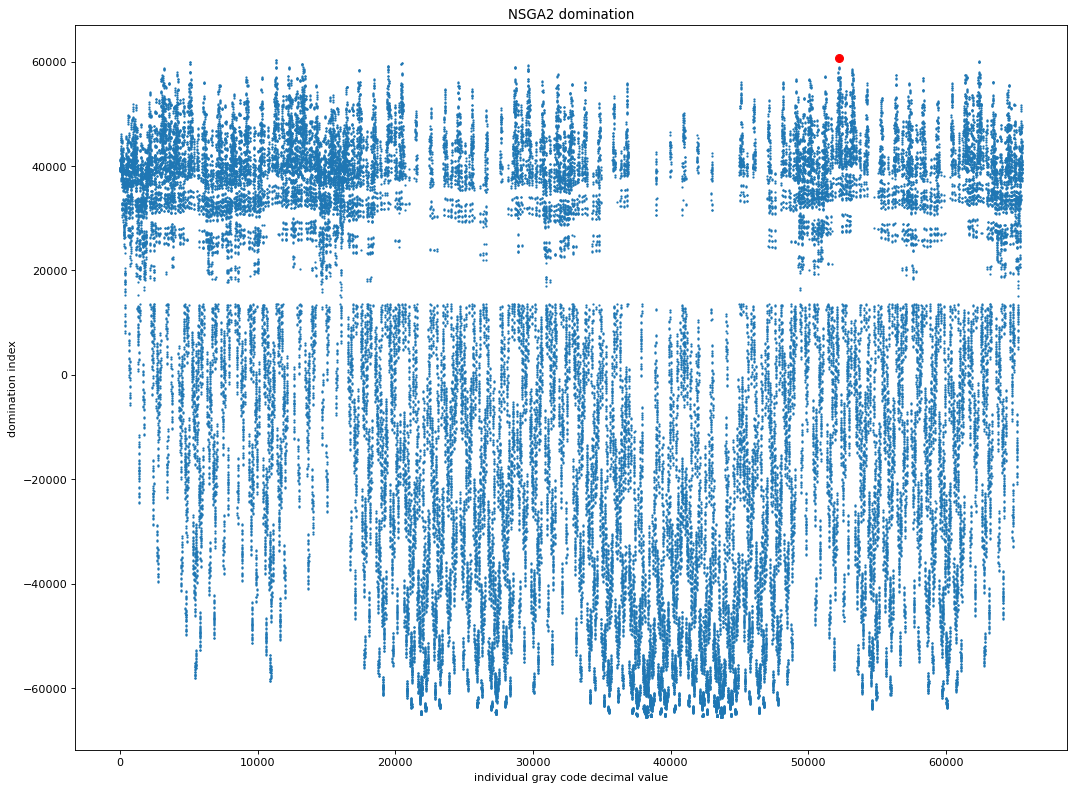

In [7]:
best_index = np.argmax(gray_code_result)
plt.figure(figsize=(16, 12), dpi=80)
plt.title("NSGA2 domination")
plt.xlabel("individual gray code decimal value")
plt.ylabel("domination index")
plt.scatter(range(len(gray_code_result)),gray_code_result,s=1)
plt.scatter(best_index,gray_code_result[best_index],c="r",s=50)

In [56]:
from DataGenerator import read_data_from_file
weights, values= read_data_from_file('Data/low_correlation_24')
n_items = len(weights)

In [57]:
from numba import boolean
@njit([boolean[:, ::1]()])  # return 2d boolean array
def getEncoded():
    return np.array(
        [[boolean(number & (1 << (n_items - 1 - x))) for x in prange(n_items)] for number in prange(1<<n_items)],
        dtype=boolean)

In [58]:
population = getEncoded()

In [59]:
from numba import njit,prange
@njit("boolean(boolean[::1],boolean[::1])",nogil = True,fastmath=True)
def isDominated(first, second):
    thisWeight= 0
    thisValue = 0
    otherWeight = 0
    otherValue= 0
    for i in prange(n_items):
        if first[i]:
            thisWeight += weights[i]
            thisValue  += values[i]
        if second[i]:
            otherWeight += weights[i]
            otherValue +=values[i]
    if thisWeight>max_weight:
        thisValue = -1
    if otherWeight>max_weight:
        otherValue = -1
    return (thisValue <= otherValue and thisWeight > otherWeight) or (thisValue < otherValue and thisWeight >= otherWeight)

@njit("boolean[::1](boolean[:,::1])",nogil = True,fastmath=True,parallel = True)
def getDominated(population):
    res = np.zeros(len(population),dtype=np.bool_)
    for i in prange(len(population)):
        for j in range(len(population)):
            if isDominated(population[i],population[j]):
                res[i]=True
                break
    return res

In [60]:
%time results = getDominated(population)

CPU times: user 3min 27s, sys: 3.25 s, total: 3min 30s
Wall time: 46.9 s


In [63]:
pareto = ~results
sum(pareto)

49